# Testing differents ML models

#### Dans ce notebook, le but est de tester les modèles de sickit-learn pour trouver le meilleurs modèles sur nos données

## Chargement des données 

In [1]:
# Importing the librairies
import pandas as pd

# Exporting the csv file into a DataFrame pandas
chemin_fichier = "../data/data_cleaned.csv"
df = pd.read_csv(chemin_fichier)

In [2]:
# Convertir en entier puis extraire les deux derniers chiffres
df['arrondissement'] = df['code_postal'].astype(int) % 100

df.drop(columns="code_postal", inplace=True)
df.drop(columns='nom_commune', inplace=True)
df.drop(columns='adresse_nom_voie', inplace = True)
df.drop(columns='date_mutation', inplace=True)

In [3]:
df

,adresse_numero,adresse_code_voie,lot1_surface_carrez,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,prix_au_m2,année,arrondissement
0,13.0,9002.0,61.00,25.0,2.0,2.348168,48.884490,9508.196721,2022,18
1,51.0,1880.0,40.66,42.0,3.0,2.362871,48.863374,14879.488441,2022,3
2,134.0,3933.0,32.52,29.0,1.0,2.405513,48.872782,9840.098401,2022,20
3,9.0,3192.0,34.53,36.0,2.0,2.386648,48.869335,6371.271358,2022,20
4,18.0,4452.0,24.59,28.0,2.0,2.400622,48.852508,11386.742578,2022,20
...,...,...,...,...,...,...,...,...,...,...
73658,161.0,2112.0,50.06,52.0,3.0,2.317308,48.891974,9622.453056,2023,17
73659,25.0,2523.0,10.00,9.0,1.0,2.324411,48.884351,10700.000000,2023,17
73660,9.0,6783.0,56.88,55.0,3.0,2.347625,48.867586,12798.874824,2023,2
73661,18.0,8436.0,85.05,84.0,4.0,2.340259,48.892260,11405.055850,2023,18


## Séparation des données en train et test

In [4]:
from sklearn.model_selection import train_test_split

# On suppose que ta cible est dans la colonne 'prix_au_m2'
X = df.drop(columns='prix_au_m2')
y = df['prix_au_m2']

# Séparation des données (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Partie 1 : Entrainement de diffénrents modèles linéaires

In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Optionnel : mise à l'échelle
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Liste des modèles linéaires à tester
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "HuberRegressor": HuberRegressor()
}

# Boucle sur les modèles
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"{name}")
    print(f"  MAE  : {mae:.2f}")
    print(f"  RMSE : {rmse:.2f}")
    print(f"  R²   : {r2:.4f}")
    print("-" * 30)


LinearRegression
  MAE  : 2260.31
  RMSE : 4824.94
  R²   : 0.0946
------------------------------
Ridge
  MAE  : 2260.30
  RMSE : 4824.94
  R²   : 0.0946
------------------------------
Lasso
  MAE  : 2260.28
  RMSE : 4824.94
  R²   : 0.0946
------------------------------
ElasticNet
  MAE  : 2253.17
  RMSE : 4823.19
  R²   : 0.0953
------------------------------
HuberRegressor
  MAE  : 2144.88
  RMSE : 4862.35
  R²   : 0.0806
------------------------------


## Analyse des erreurs 

#### On a globalement de résultat médiocre, les modèles prédisent à peine mieux que juste la moyenne (R² proche de 0), et moins bien qu'un moyenne par arrondissment (cf notebook analyse-arrondissement), les MAE et RMSE sont assez conséquentes.

## Partie 2 : Entrainement d'arbre de décision et forêt aléatoire

In [6]:
from sklearn.tree import DecisionTreeRegressor

# Entraînement de l’arbre
tree = DecisionTreeRegressor(max_depth=10, random_state=42)
tree.fit(X_train, y_train)

# Prédiction
y_pred = tree.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")


MAE : 1989.07
RMSE : 4295.43
R²   : 0.2825


#### On a ici de bien meilleurs résultats que pour les modèles linéaires, surement car il gère mieux les non linéarités. Le modèle prédis également mieux que la baseline ainsi que la baseline par arrondissement , ce qui signifie qu'il prend donc en compte la rue en plus de l'arrondissement.

#### Faisons varier les hyperparamètres pour trouver la max_depth optimale

In [7]:
from tqdm import tqdm

# Dictionnaire pour stocker les erreurs
results = {
    'max_depth': [],
    'mae': [],
    'rmse': [],
    'r2': []
}

# Boucle sur différentes profondeurs d'arbre
for depth in tqdm(range(2, 31)):
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Affichage des scores
    print(f"max_depth={depth} → MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}")

    # Sauvegarde
    results['max_depth'].append(depth)
    results['mae'].append(mae)
    results['rmse'].append(rmse)
    results['r2'].append(r2)


  0%|          | 0/29 [00:00<?, ?it/s]

max_depth=2 → MAE=2318.43, RMSE=4831.72, R²=0.0921


  7%|▋         | 2/29 [00:00<00:01, 15.53it/s]

max_depth=3 → MAE=2256.69, RMSE=4756.43, R²=0.1202
max_depth=4 → MAE=2167.72, RMSE=4702.36, R²=0.1401


 14%|█▍        | 4/29 [00:00<00:02, 12.24it/s]

max_depth=5 → MAE=2168.58, RMSE=4642.04, R²=0.1620
max_depth=6 → MAE=2136.52, RMSE=4562.21, R²=0.1906


 21%|██        | 6/29 [00:00<00:02,  9.42it/s]

max_depth=7 → MAE=2099.71, RMSE=4468.38, R²=0.2235
max_depth=8 → MAE=2073.50, RMSE=4463.58, R²=0.2252


 28%|██▊       | 8/29 [00:00<00:02,  7.49it/s]

max_depth=9 → MAE=2048.21, RMSE=4399.20, R²=0.2474


 31%|███       | 9/29 [00:01<00:03,  6.63it/s]

max_depth=10 → MAE=1989.07, RMSE=4295.43, R²=0.2825


 34%|███▍      | 10/29 [00:01<00:03,  5.89it/s]

max_depth=11 → MAE=1964.50, RMSE=4294.79, R²=0.2827


 38%|███▊      | 11/29 [00:01<00:03,  5.32it/s]

max_depth=12 → MAE=1942.00, RMSE=4230.49, R²=0.3040


 41%|████▏     | 12/29 [00:01<00:03,  4.50it/s]

max_depth=13 → MAE=1922.78, RMSE=4299.97, R²=0.2809


 45%|████▍     | 13/29 [00:02<00:03,  4.18it/s]

max_depth=14 → MAE=1949.21, RMSE=4468.20, R²=0.2236


 48%|████▊     | 14/29 [00:02<00:03,  3.91it/s]

max_depth=15 → MAE=1939.51, RMSE=4573.80, R²=0.1864


 52%|█████▏    | 15/29 [00:02<00:03,  3.73it/s]

max_depth=16 → MAE=1938.36, RMSE=4550.57, R²=0.1947


 55%|█████▌    | 16/29 [00:03<00:03,  3.55it/s]

max_depth=17 → MAE=1944.93, RMSE=4754.56, R²=0.1209


 59%|█████▊    | 17/29 [00:03<00:03,  3.39it/s]

max_depth=18 → MAE=1922.24, RMSE=4605.11, R²=0.1753


 62%|██████▏   | 18/29 [00:03<00:03,  3.02it/s]

max_depth=19 → MAE=1920.78, RMSE=4651.18, R²=0.1587


 66%|██████▌   | 19/29 [00:04<00:03,  2.92it/s]

max_depth=20 → MAE=1918.78, RMSE=4636.40, R²=0.1640


 69%|██████▉   | 20/29 [00:04<00:03,  2.82it/s]

max_depth=21 → MAE=1908.30, RMSE=4670.65, R²=0.1516


 72%|███████▏  | 21/29 [00:05<00:02,  2.77it/s]

max_depth=22 → MAE=1886.93, RMSE=4568.44, R²=0.1883


 76%|███████▌  | 22/29 [00:05<00:02,  2.72it/s]

max_depth=23 → MAE=1892.51, RMSE=4630.69, R²=0.1661


 79%|███████▉  | 23/29 [00:05<00:02,  2.66it/s]

max_depth=24 → MAE=1882.32, RMSE=4665.35, R²=0.1535


 83%|████████▎ | 24/29 [00:06<00:02,  2.48it/s]

max_depth=25 → MAE=1873.93, RMSE=4642.16, R²=0.1619


 86%|████████▌ | 25/29 [00:06<00:01,  2.46it/s]

max_depth=26 → MAE=1868.39, RMSE=4673.17, R²=0.1507


 90%|████████▉ | 26/29 [00:07<00:01,  2.44it/s]

max_depth=27 → MAE=1835.00, RMSE=4533.87, R²=0.2006


 93%|█████████▎| 27/29 [00:07<00:00,  2.41it/s]

max_depth=28 → MAE=1848.69, RMSE=4701.74, R²=0.1403


 97%|█████████▋| 28/29 [00:07<00:00,  2.39it/s]

max_depth=29 → MAE=1851.24, RMSE=4681.17, R²=0.1478


100%|██████████| 29/29 [00:08<00:00,  3.44it/s]

max_depth=30 → MAE=1832.83, RMSE=4627.83, R²=0.1671


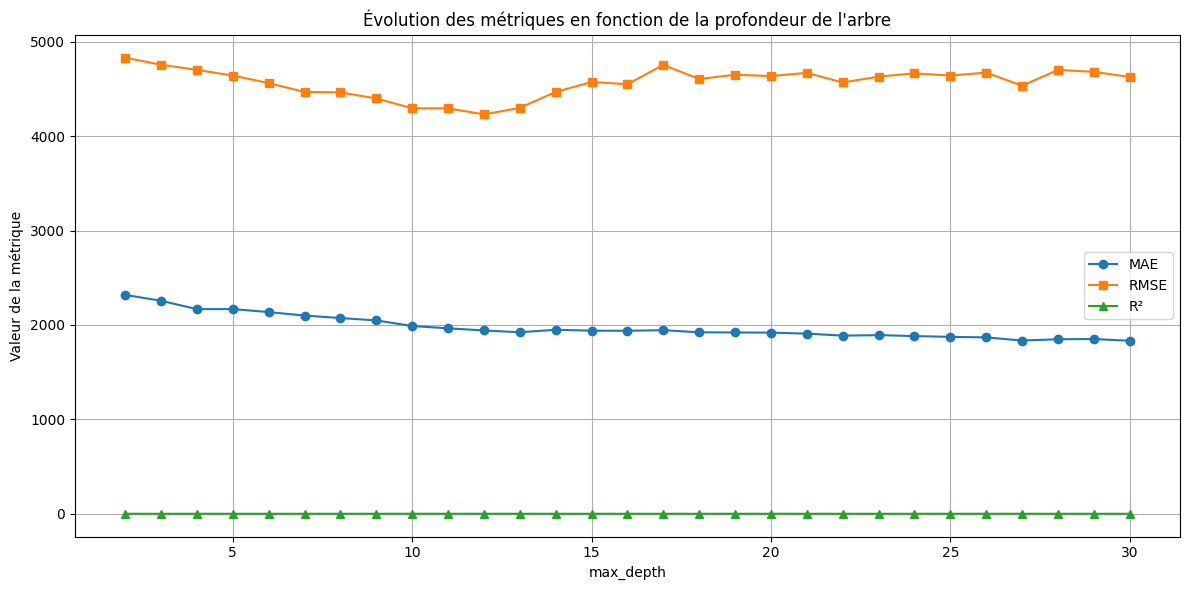

In [8]:
import matplotlib.pyplot as plt

# Tracé des courbes
plt.figure(figsize=(12, 6))

# Courbes pour chaque métrique
plt.plot(results['max_depth'], results['mae'], label='MAE', marker='o')
plt.plot(results['max_depth'], results['rmse'], label='RMSE', marker='s')
plt.plot(results['max_depth'], results['r2'], label='R²', marker='^')

# Légendes et axes
plt.xlabel('max_depth')
plt.ylabel('Valeur de la métrique')
plt.title("Évolution des métriques en fonction de la profondeur de l'arbre")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### variation en pourcetage

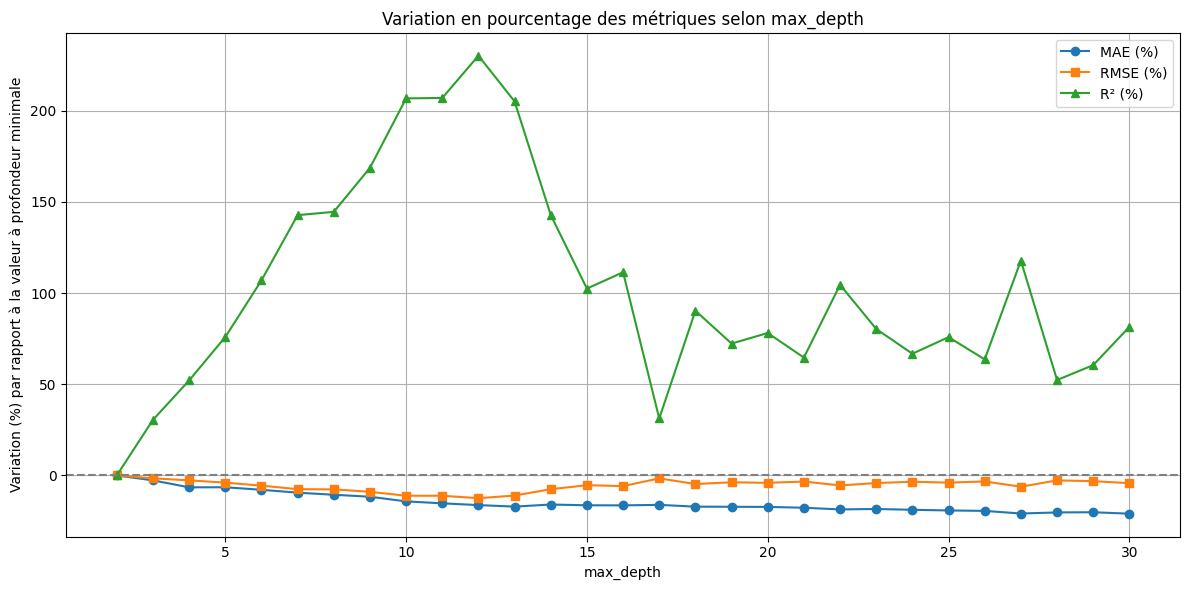

In [9]:
import matplotlib.pyplot as plt

# Calcul de la valeur initiale (profondeur minimale)
mae0 = results['mae'][0]
rmse0 = results['rmse'][0]
r2_0 = results['r2'][0]

# Calcul des variations en pourcentage
mae_pct = [(v - mae0) / mae0 * 100 for v in results['mae']]
rmse_pct = [(v - rmse0) / rmse0 * 100 for v in results['rmse']]
r2_pct = [(v - r2_0) / r2_0 * 100 for v in results['r2']]

# Tracé
plt.figure(figsize=(12, 6))

plt.plot(results['max_depth'], mae_pct, label='MAE (%)', marker='o')
plt.plot(results['max_depth'], rmse_pct, label='RMSE (%)', marker='s')
plt.plot(results['max_depth'], r2_pct, label='R² (%)', marker='^')

plt.axhline(0, color='gray', linestyle='--')

plt.xlabel('max_depth')
plt.ylabel('Variation (%) par rapport à la valeur à profondeur minimale')
plt.title("Variation en pourcentage des métriques selon max_depth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### On obtient une valeur optimale de max_depth à 12, que l'on va pouvoir tester sur une forêt aléatoire

#### Regardons les métriques pour une forêts aléatoire

In [10]:
from sklearn.ensemble import RandomForestRegressor

# Dictionnaire pour stocker les erreurs
results = {
    'n_estimators': [],
    'mae': [],
    'rmse': [],
    'r2': []
}

# Boucle sur différentes tailles de forêts
for n in tqdm(range(10, 210, 10)):  # de 10 à 200 arbres
    rf = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Affichage des scores
    print(f"n_estimators={n} → MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}")

    # Sauvegarde
    results['n_estimators'].append(n)
    results['mae'].append(mae)
    results['rmse'].append(rmse)
    results['r2'].append(r2)


  5%|▌         | 1/20 [00:00<00:16,  1.14it/s]

n_estimators=10 → MAE=1717.10, RMSE=3698.40, R²=0.4681


 10%|█         | 2/20 [00:02<00:21,  1.18s/it]

n_estimators=20 → MAE=1649.72, RMSE=3548.43, R²=0.5103


 15%|█▌        | 3/20 [00:04<00:24,  1.44s/it]

n_estimators=30 → MAE=1626.44, RMSE=3514.55, R²=0.5196


 20%|██        | 4/20 [00:06<00:31,  1.96s/it]

n_estimators=40 → MAE=1616.04, RMSE=3496.94, R²=0.5244


 25%|██▌       | 5/20 [00:09<00:34,  2.33s/it]

n_estimators=50 → MAE=1608.10, RMSE=3485.07, R²=0.5277


 30%|███       | 6/20 [00:13<00:38,  2.76s/it]

n_estimators=60 → MAE=1600.64, RMSE=3483.92, R²=0.5280


 35%|███▌      | 7/20 [00:17<00:40,  3.15s/it]

n_estimators=70 → MAE=1593.60, RMSE=3476.45, R²=0.5300


 40%|████      | 8/20 [00:21<00:41,  3.49s/it]

n_estimators=80 → MAE=1592.74, RMSE=3478.38, R²=0.5295


 45%|████▌     | 9/20 [00:26<00:43,  3.97s/it]

n_estimators=90 → MAE=1589.12, RMSE=3475.44, R²=0.5303


 50%|█████     | 10/20 [00:31<00:43,  4.39s/it]

n_estimators=100 → MAE=1585.22, RMSE=3470.19, R²=0.5317


 55%|█████▌    | 11/20 [00:37<00:43,  4.84s/it]

n_estimators=110 → MAE=1584.46, RMSE=3469.78, R²=0.5318


 60%|██████    | 12/20 [00:44<00:44,  5.51s/it]

n_estimators=120 → MAE=1583.23, RMSE=3471.06, R²=0.5314


 65%|██████▌   | 13/20 [00:52<00:42,  6.07s/it]

n_estimators=130 → MAE=1582.57, RMSE=3468.69, R²=0.5321


 70%|███████   | 14/20 [01:00<00:40,  6.72s/it]

n_estimators=140 → MAE=1580.37, RMSE=3466.42, R²=0.5327


 75%|███████▌  | 15/20 [01:09<00:37,  7.50s/it]

n_estimators=150 → MAE=1579.31, RMSE=3463.93, R²=0.5334


 80%|████████  | 16/20 [01:19<00:32,  8.22s/it]

n_estimators=160 → MAE=1576.73, RMSE=3458.96, R²=0.5347


 85%|████████▌ | 17/20 [01:30<00:27,  9.00s/it]

n_estimators=170 → MAE=1576.86, RMSE=3460.13, R²=0.5344


 90%|█████████ | 18/20 [01:42<00:19,  9.82s/it]

n_estimators=180 → MAE=1575.22, RMSE=3458.21, R²=0.5349


 95%|█████████▌| 19/20 [01:53<00:10, 10.27s/it]

n_estimators=190 → MAE=1574.59, RMSE=3456.89, R²=0.5353


100%|██████████| 20/20 [02:05<00:00,  6.25s/it]

n_estimators=200 → MAE=1574.70, RMSE=3458.31, R²=0.5349


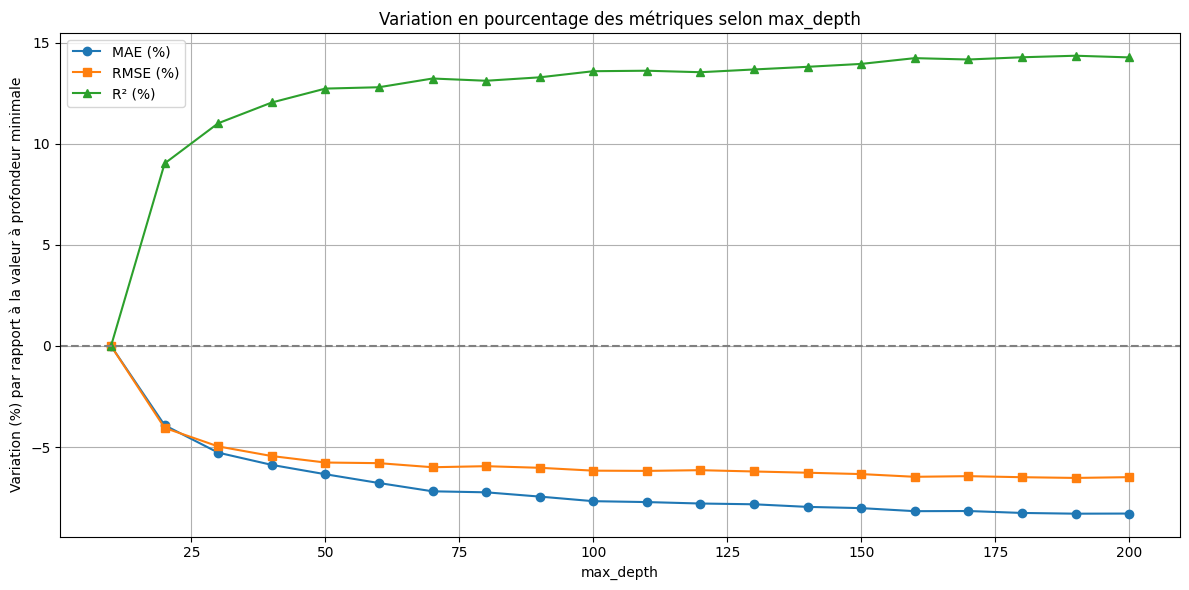

In [11]:
import matplotlib.pyplot as plt

# Calcul de la valeur initiale (profondeur minimale)
mae0 = results['mae'][0]
rmse0 = results['rmse'][0]
r2_0 = results['r2'][0]

# Calcul des variations en pourcentage
mae_pct = [(v - mae0) / mae0 * 100 for v in results['mae']]
rmse_pct = [(v - rmse0) / rmse0 * 100 for v in results['rmse']]
r2_pct = [(v - r2_0) / r2_0 * 100 for v in results['r2']]

# Tracé
plt.figure(figsize=(12, 6))

plt.plot(results['n_estimators'], mae_pct, label='MAE (%)', marker='o')
plt.plot(results['n_estimators'], rmse_pct, label='RMSE (%)', marker='s')
plt.plot(results['n_estimators'], r2_pct, label='R² (%)', marker='^')

plt.axhline(0, color='gray', linestyle='--')

plt.xlabel('max_depth')
plt.ylabel('Variation (%) par rapport à la valeur à profondeur minimale')
plt.title("Variation en pourcentage des métriques selon max_depth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### On est ici bien meilleur que le decision tree, ce qui est logique, l'erreur R² est assez convaincante, de même pour la MAE.

## Partie 3 : Boosting Models

In [16]:
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

models = {
    "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=200, learning_rate=0.9, max_depth=30),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(max_iter=100)
}


# Boucle sur les modèles de boosting
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"{name}")
    print(f"  MAE  : {mae:.2f}")
    print(f"  RMSE : {rmse:.2f}")
    print(f"  R²   : {r2:.4f}")
    print("-" * 30)


GradientBoostingRegressor
  MAE  : 1763.36
  RMSE : 4339.67
  R²   : 0.2676
------------------------------
HistGradientBoostingRegressor
  MAE  : 2017.71
  RMSE : 4245.89
  R²   : 0.2989
------------------------------


## Partie 4 : modèle KNN

In [19]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler


# normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
for k in range(5,100,5):
    # Modèle KNN
    knn_model = KNeighborsRegressor(n_neighbors=k, weights='distance')  
    knn_model.fit(X_train_scaled, y_train)

    # Prédictions
    y_pred = knn_model.predict(X_test_scaled)

    # Évaluation
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"k = {k}")
    print(f"  MAE  : {mae:.2f}")
    print(f"  RMSE : {rmse:.2f}")
    print(f"  R²   : {r2:.4f}")
    print("-" * 30)


k = 5
  MAE  : 1587.01
  RMSE : 4005.79
  R²   : 0.3760
------------------------------
k = 10
  MAE  : 1530.20
  RMSE : 3880.78
  R²   : 0.4143
------------------------------
k = 15
  MAE  : 1497.99
  RMSE : 3813.38
  R²   : 0.4345
------------------------------
k = 20
  MAE  : 1485.38
  RMSE : 3788.88
  R²   : 0.4417
------------------------------
k = 25
  MAE  : 1479.19
  RMSE : 3777.03
  R²   : 0.4452
------------------------------
k = 30
  MAE  : 1476.99
  RMSE : 3775.27
  R²   : 0.4457
------------------------------
k = 35
  MAE  : 1472.62
  RMSE : 3766.84
  R²   : 0.4482
------------------------------
k = 40
  MAE  : 1466.28
  RMSE : 3755.68
  R²   : 0.4515
------------------------------
k = 45
  MAE  : 1459.92
  RMSE : 3743.72
  R²   : 0.4549
------------------------------
k = 50
  MAE  : 1457.20
  RMSE : 3736.14
  R²   : 0.4571
------------------------------
k = 55
  MAE  : 1454.60
  RMSE : 3733.54
  R²   : 0.4579
------------------------------
k = 60
  MAE  : 1452.86
  RMSE : 

## Partie 5 : résaux de Neurones

In [20]:
from sklearn.neural_network import MLPRegressor

# MLP = très sensible aux échelles → normalisation indispensable
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modèle MLP (réseau de neurones)
mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 64),  # 2 couches de 64 neurones
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)
mlp_model.fit(X_train_scaled, y_train)

# Prédictions
y_pred = mlp_model.predict(X_test_scaled)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MLPRegressor")
print(f"  MAE  : {mae:.2f}")
print(f"  RMSE : {rmse:.2f}")
print(f"  R²   : {r2:.4f}")
print("-" * 30)


MLPRegressor
  MAE  : 2119.03
  RMSE : 4644.53
  R²   : 0.1611
------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np

# ⚠️ MLP nécessite un scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Grille d'hyperparamètres à tester
hidden_layer_options = [
    (32,), (64,), (128,),
    (64, 64), (128, 64), (128, 128)
]
activations = ['relu', 'tanh']
learning_rates = [0.001, 0.01]
max_iters = [300, 500]

# Pour stocker les meilleurs résultats
best_score = -np.inf
best_config = None

print("🔍 Testing MLPRegressor configurations...\n")
for hl in tqdm(hidden_layer_options, desc="Hidden Layers"):
    for act in activations:
        for lr in learning_rates:
            for mi in max_iters:
                model = MLPRegressor(
                    hidden_layer_sizes=hl,
                    activation=act,
                    learning_rate_init=lr,
                    max_iter=mi,
                    random_state=42
                )

                try:
                    model.fit(X_train_scaled, y_train)
                    y_pred = model.predict(X_test_scaled)

                    mae = mean_absolute_error(y_test, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    r2 = r2_score(y_test, y_pred)

                    print(f"Config: hl={hl}, act={act}, lr={lr}, max_iter={mi}")
                    print(f"  MAE  : {mae:.2f} | RMSE : {rmse:.2f} | R² : {r2:.4f}")
                    print("-" * 50)

                    if r2 > best_score:
                        best_score = r2
                        best_config = {
                            'hidden_layers': hl,
                            'activation': act,
                            'learning_rate': lr,
                            'max_iter': mi,
                            'mae': mae,
                            'rmse': rmse,
                            'r2': r2
                        }

                except Exception as e:
                    print(f"⚠️ Failed config: {hl}, {act}, {lr}, {mi} → {e}")

# Résultat final
print("\n✅ Best configuration found:")
print(best_config)


🔍 Testing MLPRegressor configurations...



Hidden Layers:   0%|          | 0/6 [00:00<?, ?it/s]/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(32,), act=relu, lr=0.001, max_iter=300
  MAE  : 2232.43 | RMSE : 4781.35 | R² : 0.1109
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(32,), act=relu, lr=0.001, max_iter=500
  MAE  : 2219.22 | RMSE : 4769.02 | R² : 0.1155
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(32,), act=relu, lr=0.01, max_iter=300
  MAE  : 2108.27 | RMSE : 4697.10 | R² : 0.1420
--------------------------------------------------
Config: hl=(32,), act=relu, lr=0.01, max_iter=500
  MAE  : 2131.14 | RMSE : 4697.53 | R² : 0.1418
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(32,), act=tanh, lr=0.001, max_iter=300
  MAE  : 8416.51 | RMSE : 9824.74 | R² : -2.7538
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(32,), act=tanh, lr=0.001, max_iter=500
  MAE  : 6499.15 | RMSE : 8227.68 | R² : -1.6326
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(32,), act=tanh, lr=0.01, max_iter=300
  MAE  : 2158.88 | RMSE : 4711.67 | R² : 0.1367
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
Hidden Layers:  17%|█▋        | 1/6 [01:38<08:11, 98.24s/it]

Config: hl=(32,), act=tanh, lr=0.01, max_iter=500
  MAE  : 2165.32 | RMSE : 4703.10 | R² : 0.1398
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(64,), act=relu, lr=0.001, max_iter=300
  MAE  : 2196.59 | RMSE : 4754.63 | R² : 0.1208
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(64,), act=relu, lr=0.001, max_iter=500
  MAE  : 2161.55 | RMSE : 4729.74 | R² : 0.1300
--------------------------------------------------
Config: hl=(64,), act=relu, lr=0.01, max_iter=300
  MAE  : 2111.44 | RMSE : 4690.99 | R² : 0.1442
--------------------------------------------------
Config: hl=(64,), act=relu, lr=0.01, max_iter=500
  MAE  : 2111.44 | RMSE : 4690.99 | R² : 0.1442
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(64,), act=tanh, lr=0.001, max_iter=300
  MAE  : 5642.62 | RMSE : 7552.93 | R² : -1.2185
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(64,), act=tanh, lr=0.001, max_iter=500
  MAE  : 2717.75 | RMSE : 5400.36 | R² : -0.1342
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(64,), act=tanh, lr=0.01, max_iter=300
  MAE  : 2165.13 | RMSE : 4692.85 | R² : 0.1435
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
Hidden Layers:  33%|███▎      | 2/6 [03:46<07:42, 115.65s/it]

Config: hl=(64,), act=tanh, lr=0.01, max_iter=500
  MAE  : 2169.34 | RMSE : 4684.30 | R² : 0.1467
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(128,), act=relu, lr=0.001, max_iter=300
  MAE  : 2153.28 | RMSE : 4727.07 | R² : 0.1310
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(128,), act=relu, lr=0.001, max_iter=500
  MAE  : 2125.02 | RMSE : 4714.24 | R² : 0.1357
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(128,), act=relu, lr=0.01, max_iter=300
  MAE  : 2117.30 | RMSE : 4681.72 | R² : 0.1476
--------------------------------------------------
Config: hl=(128,), act=relu, lr=0.01, max_iter=500
  MAE  : 2104.40 | RMSE : 4676.61 | R² : 0.1495
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(128,), act=tanh, lr=0.001, max_iter=300
  MAE  : 2519.89 | RMSE : 5084.01 | R² : -0.0052
--------------------------------------------------
Config: hl=(128,), act=tanh, lr=0.001, max_iter=500
  MAE  : 2616.70 | RMSE : 5071.76 | R² : -0.0004
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(128,), act=tanh, lr=0.01, max_iter=300
  MAE  : 2144.14 | RMSE : 4670.92 | R² : 0.1515
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
Hidden Layers:  50%|█████     | 3/6 [07:00<07:34, 151.54s/it]

Config: hl=(128,), act=tanh, lr=0.01, max_iter=500
  MAE  : 2145.67 | RMSE : 4663.69 | R² : 0.1542
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(64, 64), act=relu, lr=0.001, max_iter=300
  MAE  : 2121.09 | RMSE : 4683.37 | R² : 0.1470
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(64, 64), act=relu, lr=0.001, max_iter=500
  MAE  : 2119.03 | RMSE : 4644.53 | R² : 0.1611
--------------------------------------------------
Config: hl=(64, 64), act=relu, lr=0.01, max_iter=300
  MAE  : 2154.65 | RMSE : 4681.24 | R² : 0.1478
--------------------------------------------------
Config: hl=(64, 64), act=relu, lr=0.01, max_iter=500
  MAE  : 2154.65 | RMSE : 4681.24 | R² : 0.1478
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(64, 64), act=tanh, lr=0.001, max_iter=300
  MAE  : 5670.81 | RMSE : 7574.68 | R² : -1.2313
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(64, 64), act=tanh, lr=0.001, max_iter=500
  MAE  : 2729.08 | RMSE : 5410.21 | R² : -0.1383
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(64, 64), act=tanh, lr=0.01, max_iter=300
  MAE  : 2219.69 | RMSE : 4470.04 | R² : 0.2229
--------------------------------------------------


Hidden Layers:  67%|██████▋   | 4/6 [11:01<06:14, 187.09s/it]

Config: hl=(64, 64), act=tanh, lr=0.01, max_iter=500
  MAE  : 2279.12 | RMSE : 4442.79 | R² : 0.2324
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(128, 64), act=relu, lr=0.001, max_iter=300
  MAE  : 2108.36 | RMSE : 4663.11 | R² : 0.1544
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(128, 64), act=relu, lr=0.001, max_iter=500
  MAE  : 2130.72 | RMSE : 4637.65 | R² : 0.1636
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(128, 64), act=relu, lr=0.01, max_iter=300
  MAE  : 2208.46 | RMSE : 4509.25 | R² : 0.2092
--------------------------------------------------
Config: hl=(128, 64), act=relu, lr=0.01, max_iter=500
  MAE  : 2104.03 | RMSE : 4498.32 | R² : 0.2131
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(128, 64), act=tanh, lr=0.001, max_iter=300
  MAE  : 5675.22 | RMSE : 7578.09 | R² : -1.2333
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(128, 64), act=tanh, lr=0.001, max_iter=500
  MAE  : 2730.89 | RMSE : 5411.78 | R² : -0.1390
--------------------------------------------------
Config: hl=(128, 64), act=tanh, lr=0.01, max_iter=300
  MAE  : 2617.28 | RMSE : 5071.80 | R² : -0.0004
--------------------------------------------------


Hidden Layers:  83%|████████▎ | 5/6 [15:45<03:41, 221.97s/it]

Config: hl=(128, 64), act=tanh, lr=0.01, max_iter=500
  MAE  : 2617.28 | RMSE : 5071.80 | R² : -0.0004
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(128, 128), act=relu, lr=0.001, max_iter=300
  MAE  : 2142.56 | RMSE : 4663.04 | R² : 0.1544
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(128, 128), act=relu, lr=0.001, max_iter=500
  MAE  : 2163.03 | RMSE : 4639.04 | R² : 0.1631
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(128, 128), act=relu, lr=0.01, max_iter=300
  MAE  : 2092.00 | RMSE : 4275.77 | R² : 0.2890
--------------------------------------------------
Config: hl=(128, 128), act=relu, lr=0.01, max_iter=500
  MAE  : 2076.90 | RMSE : 4215.28 | R² : 0.3090
--------------------------------------------------


/Users/theodorefischer/Desktop/ENSTA/IA/IA26/nom_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Config: hl=(128, 128), act=tanh, lr=0.001, max_iter=300
  MAE  : 2513.76 | RMSE : 5087.66 | R² : -0.0066
--------------------------------------------------
Config: hl=(128, 128), act=tanh, lr=0.001, max_iter=500
  MAE  : 2616.85 | RMSE : 5071.77 | R² : -0.0004
--------------------------------------------------
Config: hl=(128, 128), act=tanh, lr=0.01, max_iter=300
  MAE  : 2618.05 | RMSE : 5071.86 | R² : -0.0004
--------------------------------------------------


Hidden Layers: 100%|██████████| 6/6 [21:34<00:00, 215.74s/it]

Config: hl=(128, 128), act=tanh, lr=0.01, max_iter=500
  MAE  : 2618.05 | RMSE : 5071.86 | R² : -0.0004
--------------------------------------------------

✅ Best configuration found:
{'hidden_layers': (128, 128), 'activation': 'relu', 'learning_rate': 0.01, 'max_iter': 500, 'mae': 2076.898175426154, 'rmse': np.float64(4215.277856708687), 'r2': 0.30898648378056737}


## Conclusion : 

1. Les modèles linéaires sont mauvais  
2. Les arbres de décision sont bons  
3. Les modèles boost sont bons  
4. Les modèles de KNN sont bons  
5. Les modèles MLP sont mauvais (ou bien trop complexe à calibrer)